**Nom du / des étudiant(s)** : Mamisoa RANDRIANARIMANANA - Xianxiang ZHANG

# TP image - Classification d'images

Les TP de traitement d'images sont réalisés en Python3, à l'aide de la librairie [scikit-image](http://scikit-image.org/docs/stable/). Les tableaux utilisés  (`ndarray`) par cette librairie pour manipuler les images proviennent de la librairie [numpy](https://docs.scipy.org/doc/). L'affichage des images et autres figures est réalisé grace à [plotly](https://plotly.com/python/). La documentation de ces trois librairies vous sera donc bien utile.

Dans ce TP, les questions seront indiquées dans un bloc **question**, et les réponses seront à donner dans le bloc **réponse**  situé en dessous du bloc de question. Vos réponses sont à rédiger en [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). Vous pourrez ainsi répondre non seulement avec du texte, mais aussi avec des tableaux et des images.

Ce TP est à réaliser en deux séances d'1h30.

**Remarque importante:** Les questions posées dans ce TP requièrent généralement des <u>réponses courtes mais justifées</u>. Un simple oui ou non ne nous est d'aucune utilité pour juger de votre compréhension de la question et de sa réponse...

**Autre remarque:** Il y a parfois plusieurs sous-questions dans une même question. <u>Pensez a répondre à toutes les sous-questions</u>.


In [ ]:
from skimage import data, filters, io
import plotly.express as px  # gestion des figures
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import scipy.stats as stats
import math
from numba import jit

## Preliminaire : le code vectorisé  

Dans cette petite manipulation préliminaire python, on examine deux façons d'écrire un algorithme de seuillage d'image. L'opération sur l'image considérée ici est un exemple simple quelconque, le sujet est la ** vectorisation de code **.

Boucle déroulée
225 ms ± 9.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

 
 Boucle déroulée en compilation juste à temps
215 µs ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

 
 Code vectorisé
10.9 µs ± 84.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)



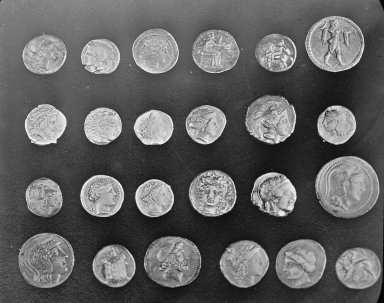
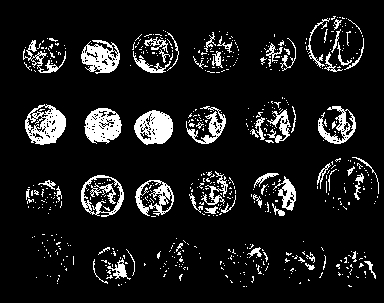

In [ ]:
image = data.coins() # Une image avec des pieces de monnaie, fournie dans la librairie python

nb_lignes, nb_colonnes = image.shape

seuil=175

def seuillage_deroule(image): # La fonction naïve 
    image_seuillee = np.copy(image)
    for i in range(nb_lignes):
        for j in range(nb_colonnes):
            if image[i,j]>seuil:
                image_seuillee[i,j]=255
            else:
                image_seuillee[i,j]=0
    return(image_seuillee)

def seuillage_vectorise(image): # La fonction moins naïve
    image_seuillee = np.copy(image)
    image_seuillee = image>seuil
    return(image_seuillee)

@jit(nopython=False)
def seuillage_deroule_jit(image): # La fonction naïve en version compilée juste à temps (jit)
    image_seuillee = np.copy(image)
    for i in range(nb_lignes):
        for j in range(nb_colonnes):
            if image[i,j]>seuil:
                image_seuillee[i,j]=255
            else:
                image_seuillee[i,j]=0
    return(image_seuillee)

print ("Boucle déroulée")
%timeit image_seuillee = seuillage_deroule(image)
print ("\n \n Boucle déroulée en compilation juste à temps")
%timeit image_seuillee = seuillage_deroule_jit(image)
print ("\n \n Code vectorisé")
%timeit image_seuillee = seuillage_vectorise(image)

#pour pouvoir afficher l'image seuillée
image_seuillee = seuillage_vectorise(image)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Image originale', 'Image seuillée'))
fig.add_trace( px.imshow(image, binary_string=True).data[0], row=1, col=1)
fig.add_trace( px.imshow(image_seuillee, binary_string=True).data[0], row=1, col=2)
fig.show()

**Question 1:**
* Que fait le code ci-dessus ?
* Quelle fonction de seuillage est plus facile à lire ?
* Laquelle est plus facile à maintenir ?
* Quel est le rapport (ratio) des temps d'execution entre les trois procédés ? (expliquer les raisons techniques)



**Réponse 1:** 
Le code ci-dessous permet de transformer tous les pixels ayant une valeur de niveau de gris supérieur à une valeur qu'on appelle seuil en noir et ceux qui ont une valeur inférieur en blanc. Ainsi les valeurs de pixels supérieur à 145 prennent la valeur 255 et ceux inférieurs deviennent 0. 
La version naive de la fonction de seuillage est plus facile à lire. En revanche, la version moins naive est plus facile a maintenir car le code est vectorisé. Le rapport des temps d'execution entre la fonction naive et la fonction moins naive est est : (217 * 10^-3)/(91.6 * 10^-6) = 2.37 * 10^3 ~ 10^3 qui assez élevé. Ceci peut être expliquer par la vectorisation du code en faisant directement des opérations sur des vecteurs (comme dans la fonction moins naive) au lieu de faire plusieurs boucles for (comme dans la version naive) qui sont assez couteux sur python en terme de temps d'execution. Le rapport des temps d'execution entre la fonction naive version compilé et la version non compilé est  (217 * 10^-3)/(82.9 * 10^-6) = 2.61 * 10^3 ~ 10^3 qui également élevé et de même ordre de grandeur que le rapport précédent. Ceci est lié au fait que dans la version compilé le code source est compilée en avance en bytecode. Le rapport des temps d'execution entre la fonction naive version compilé et la version moins naive est proche de 1 c'est à dire qu'ils ont à peut près le même temps d'execution.

Le même principe s'applique pour des programmes en R, en Matlab, en Julia (un langage/environnement qui ressemble à python mais se donne pour objectif d'être rapide à l'execution comme du C http://julialang.org), même si ce dernier se donne pour objectif d'être aussi rapide pour l'écriture "déroulée" du code - car tous les algorithmes ne peuvent pas se vectoriser.

## Détection de contours

Cette section examine une manière simple de détecter des contours dans des images. Les contours peuvent ensuite servir à reconnaître l'objet selon sa forme, ou le point de vue 3D de la caméra sur cet objet, ou encore à faire un suivi de cet objet dans une séquence d'images.

On va utiliser la convolution de l'image avec des filtres de Sobel (deux filtres : un horizontal et un vertical) pour détecter la présence de contours. 


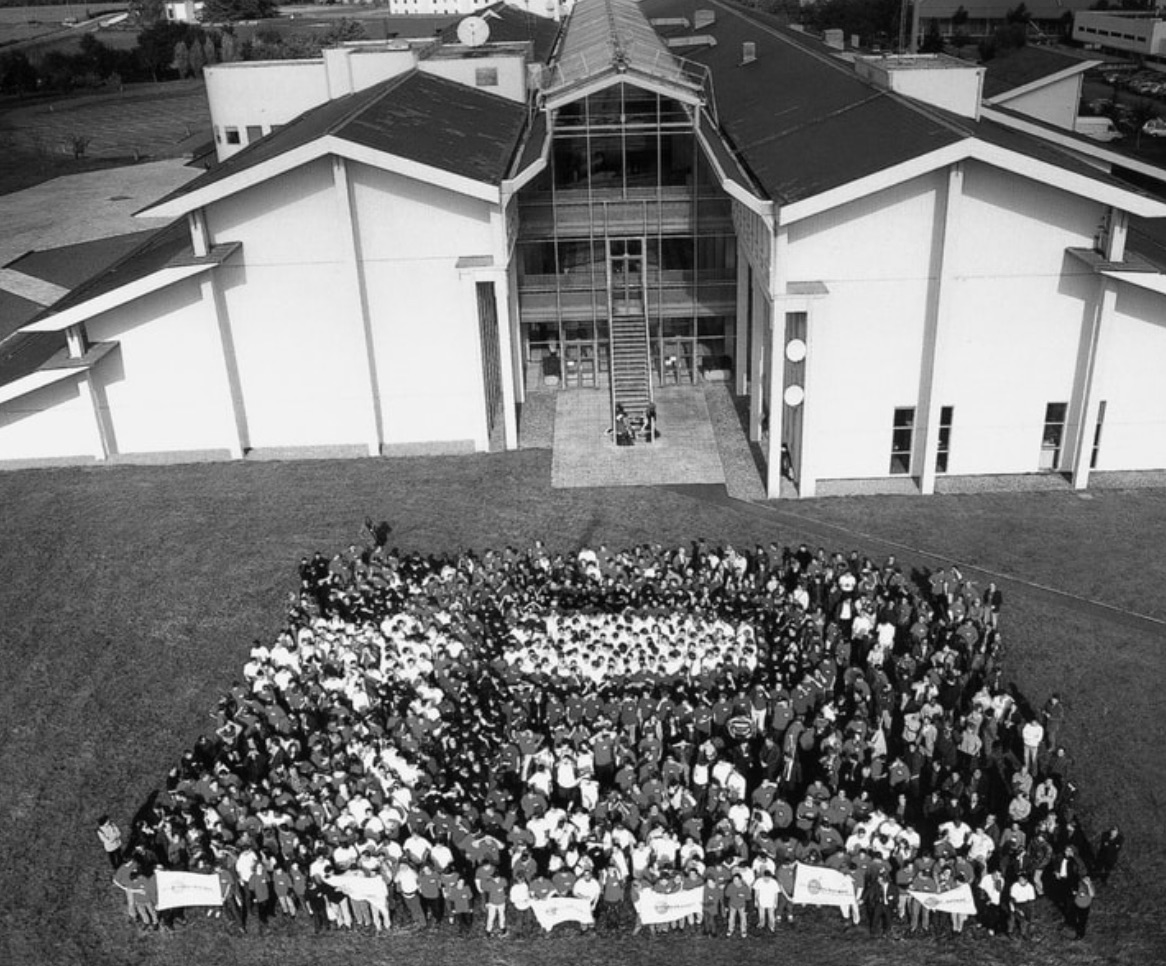
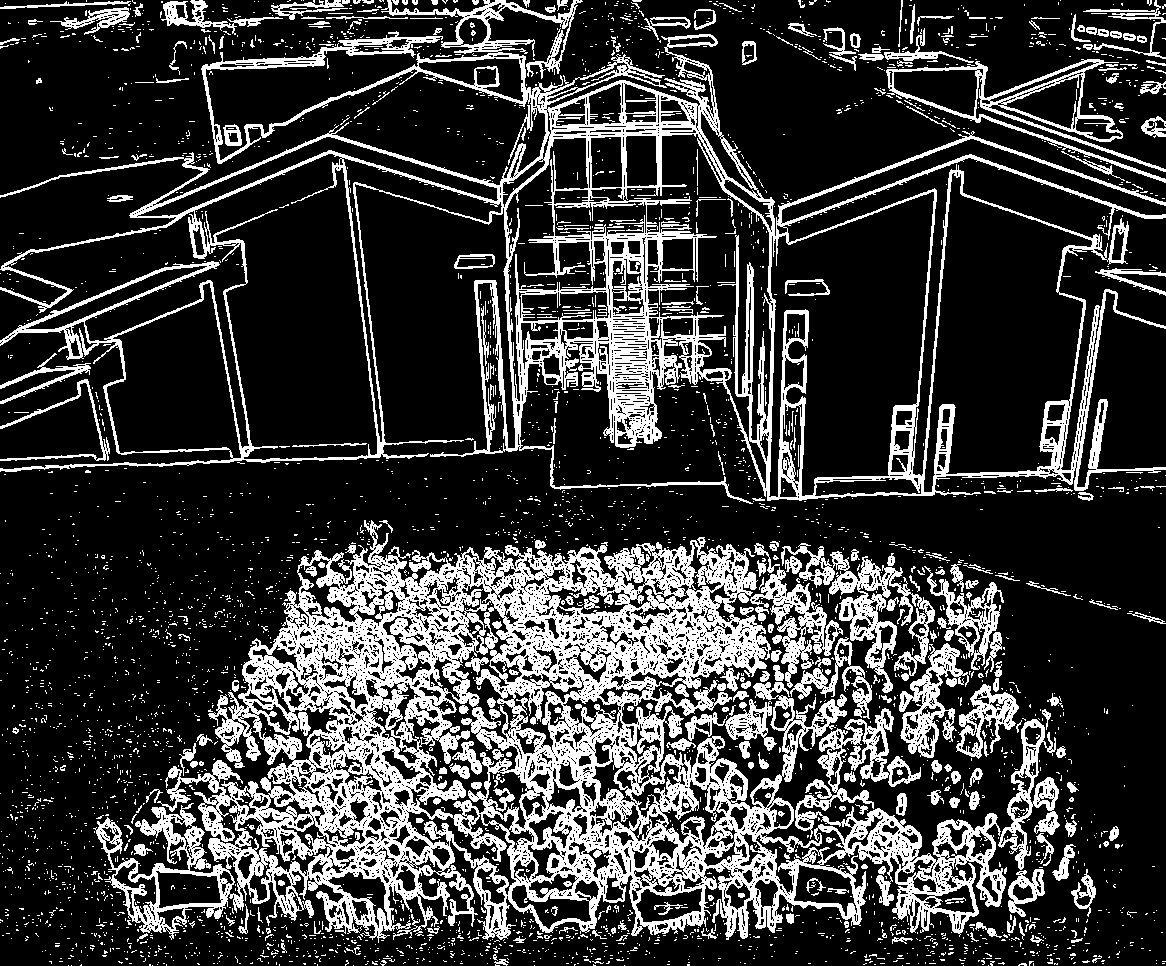


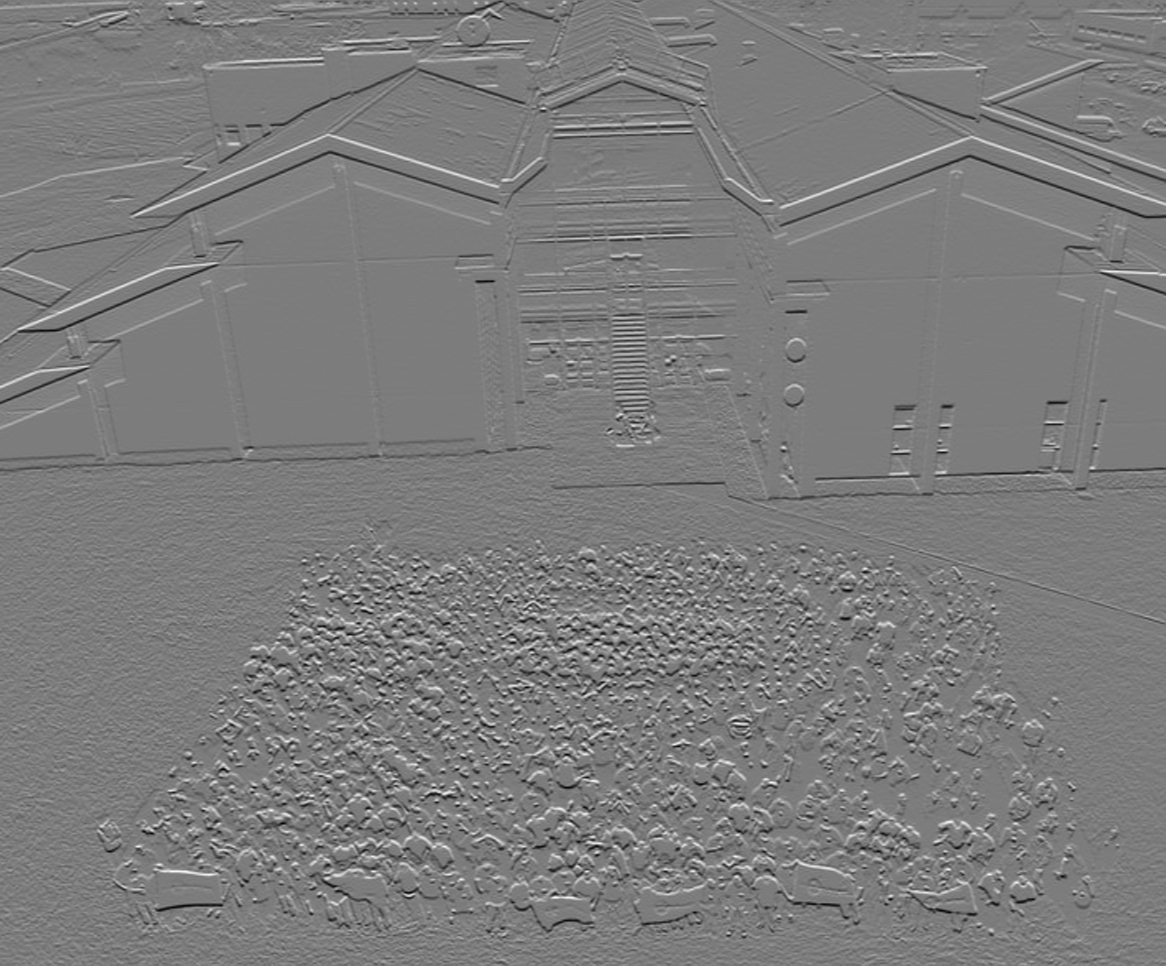
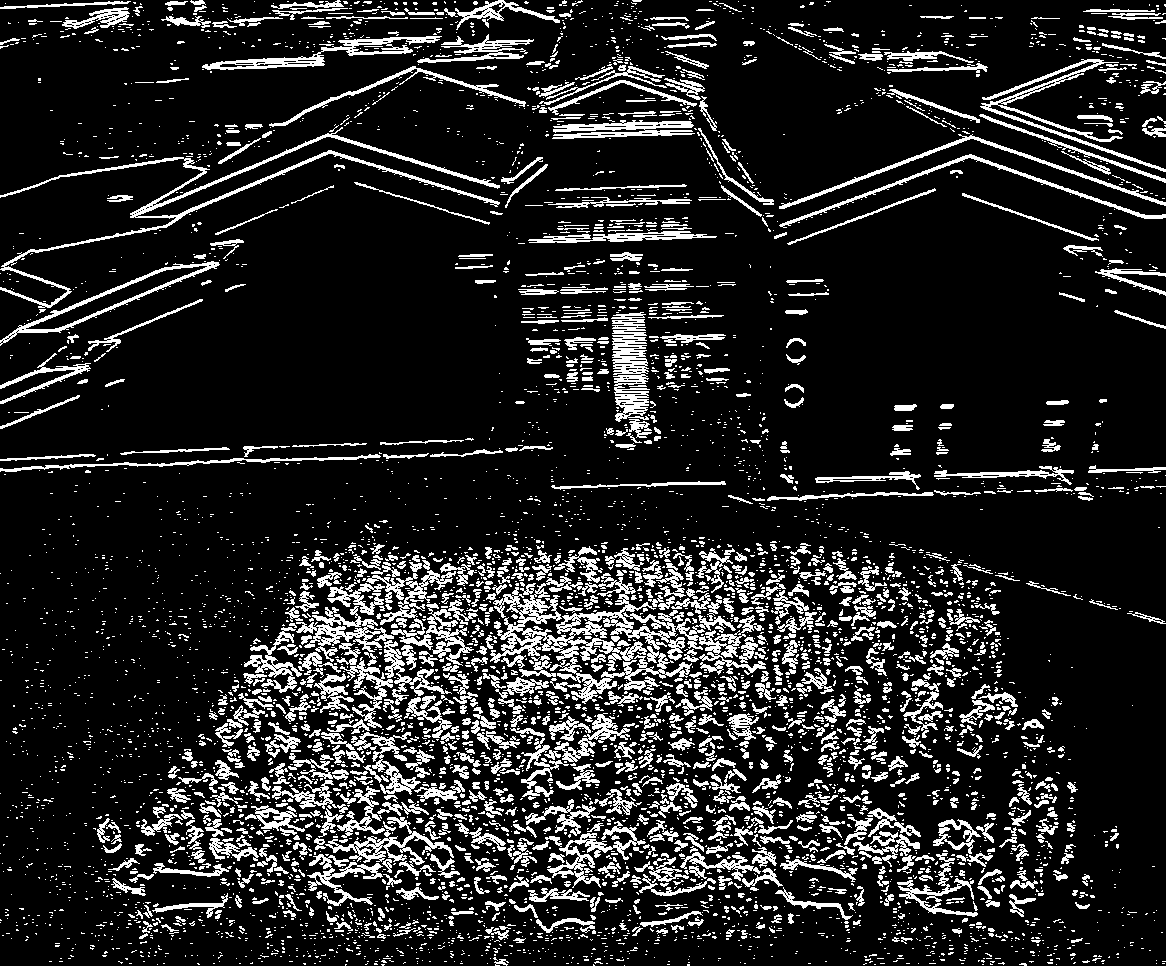


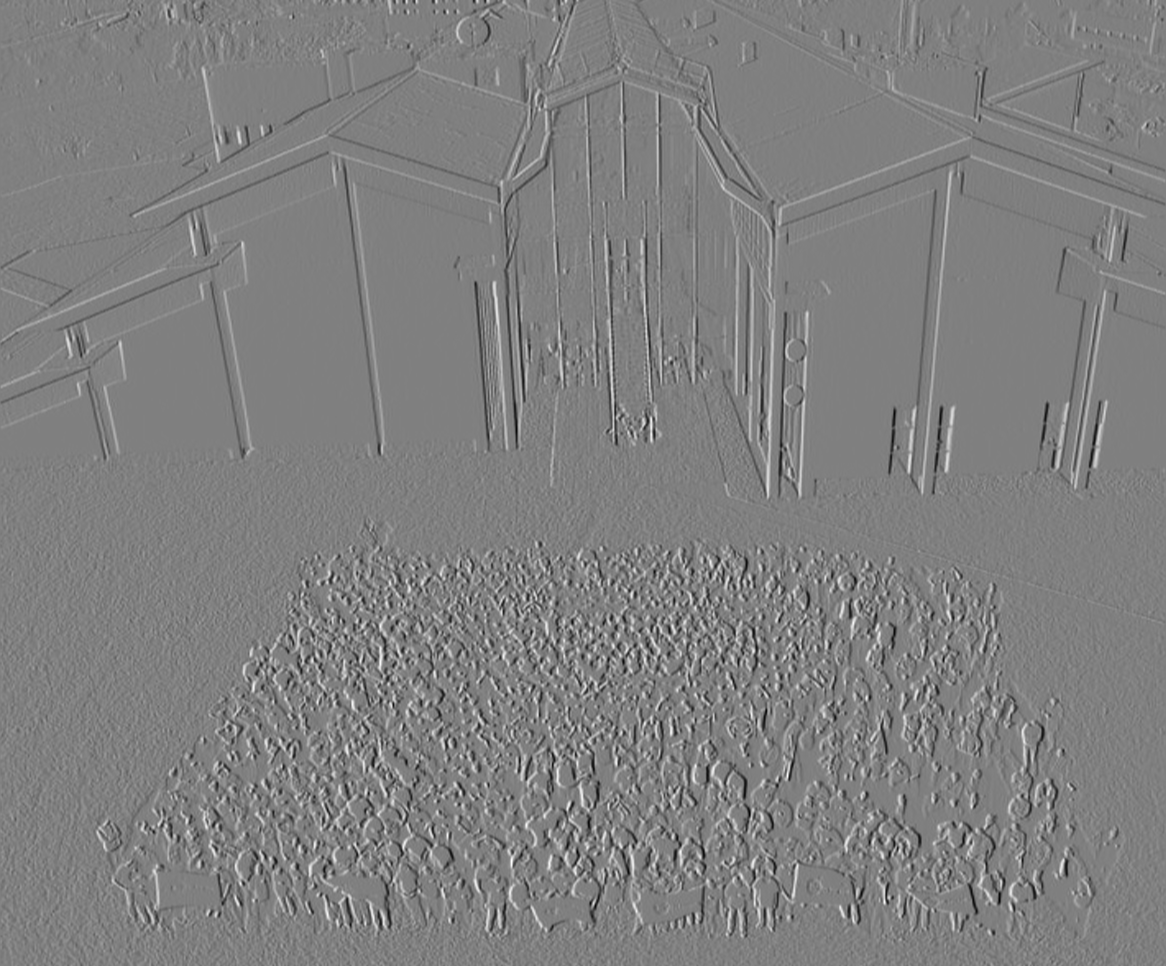
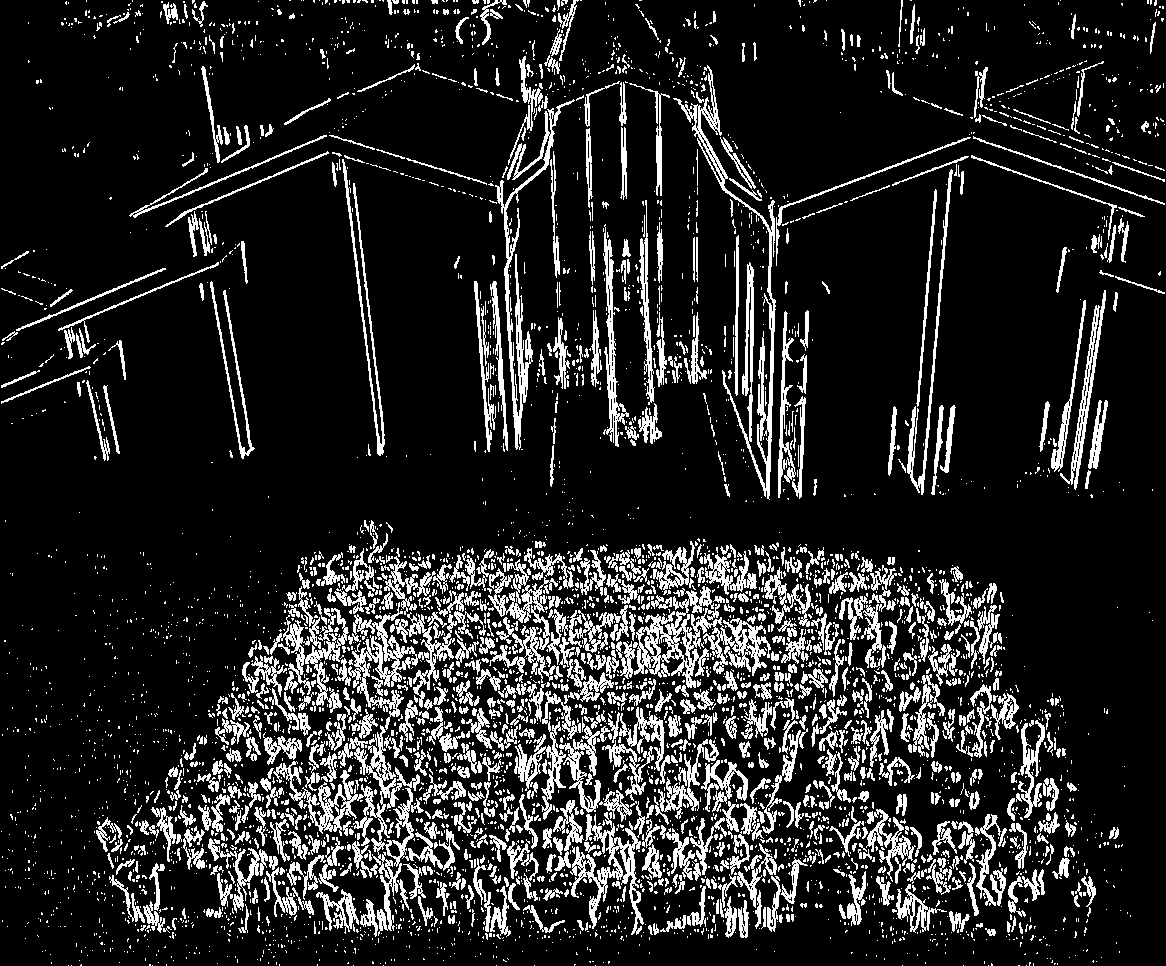

In [ ]:
from skimage import filters,feature
from skimage.color import rgb2gray

#im = data.coins() #enlever le commentaire pour utiliser cette image
im = rgb2gray(io.imread("polytech.jpg"))
#im = data.camera()

# Regarder si un filtrage passe-bas préalable améliore le résultat 
# im=filters.gaussian(im, sigma=2)

seuil = 0.1

sx = filters.sobel_h(im)
ssx = abs(sx)>seuil
sy = filters.sobel_v(im)
ssy = abs(sy)>seuil

ss = np.maximum(ssx,ssy)

# On affiche l'image originae et les contours détectés
fig = make_subplots(rows=1, cols=2, subplot_titles=('Image originale', 'Contours détectés'))
fig.add_trace( px.imshow(im, binary_string=True).data[0], row=1, col=1)
fig.add_trace( px.imshow(ss, binary_string=True).data[0], row=1, col=2)
fig.show()

# Quelques détails sur les filtres de sobel utiliés pour détecter les contours
fig = make_subplots(rows=1, cols=2, subplot_titles=('Filtrage avec Sobel horizontal', 'Version seuillée'))
fig.add_trace( px.imshow(sx, binary_string=True).data[0], row=1, col=1)
fig.add_trace( px.imshow(ssx, binary_string=True).data[0], row=1, col=2)
fig.show()
fig = make_subplots(rows=1, cols=2, subplot_titles=('Filtrage avec Sobel vertical', 'Version seuillée'))
fig.add_trace( px.imshow(sy, binary_string=True).data[0], row=1, col=1)
fig.add_trace( px.imshow(ssy, binary_string=True).data[0], row=1, col=2)
fig.show()

#from skimage.morphology import erosion, dilation, opening, closing
#from skimage.morphology import disk

#struct_elem = disk(4)

#dilated = dilation(ss, struct_elem)
#eroded = erosion(dilated, struct_elem)

#canny = feature.canny(im)

#fig = make_subplots(rows=1, cols=2, subplot_titles=('Après dilatation puis erosion', 'Méthode de canny'))
#sub = px.imshow(eroded, binary_string=True)
#fig.add_trace( sub.data[0], row=1, col=1)
#sub = px.imshow(canny, binary_string=True)
#fig.add_trace( sub.data[0], row=1, col=2)
#fig.show()

**Question 2:**
* Trouver sur internet les valeurs de ces filtres de Sobel : expliquer les signes des valeurs numériques, les directionalités de ces filtres
* La convolution de l'image avec ces filtres aboutit-elle directement à une décision (binaire) par pixel ?
* Vérifier sur l'experience ci-dessous que les contours horizontaux et verticaux sont bien détectés selon le filtre employé.
* Comment combine t-on dans le code les résultats des détections horizontale et verticale ? (on pourrait procéder différemment)
* La détection d'un contour en un pixel dépend t-elle de ce qui est décidé aux pixels voisins ? Est-ce le procédé qui semble le plus intéressant pour obtenir des détections de contours fiables (le résultat de la détection de contour par la méthode de Canny est fourni en bas à droite) ?

**Réponse 2:** Le filtre de Sobel est un opérateur utilisé en traitement d'image pour la détection de contours et a pour but de calculer le gradient de l'intensité de chaque pixel qui indique la direction de la plus forte variation du clair au sombre, mais aussi le taux de changement dans cette direction. On connaît alors les points de changement tout à coup de luminosité, correspondant certainement à des bords, mais aussi l'orientation de ces bords.  En chaque point, le gradient pointe dans la direction du plus fort changement d'intensité, et sa longueur représente le taux de variation dans cette direction. Le gradient dans une zone d'intensité constante est par conséquent nul. Au niveau d'un contour, le gradient traverse le contour, des intensités les plus sombres aux intensités les plus claires.

Soit I l'image source,G(x) et G(y) deux images qui en chaque point contiennent des approximations respectivement de la dérivée horizontale et verticale de chaque point. Ces images sont calculées comme suit:
G(x)=([1, 0, -1][2, 0, -2][1, 0, -1])* A et G(y)= ([1, 2, 1][0, 0, 0][-1, -2, -1]) * A. 

On peut voir que les contours horizontaux et verticaux sont bien détectés selon le filtre employé.

le code les résultats des détections horizontale et verticale est combiné comme suit  pour obtenir une approximation de la norme du gradient : $\sqrt{G(x)^2+G(y)^2}$

La détection de contour dépend de ce qui est décidé aux pixels voisins. Afin d'obtenir des détections de contours fiables, ce procédé n'est pas la plus sur car l'algorithme de Sobel calcule une approximation assez incorrecte du gradient d'intensité. En effet, il n'utilise qu'un voisinage (généralement de taille 3×3) autour de chaque point pour calculer le gradient, et les poids utilisés pour le calcul du gradient sont entiers.Cependant, elle reste suffisant pour de nombreux cas pratiques. 


# Détection des pièces

Pour l'image de pièces ci-dessous, le but est de décider correctement pour chaque pixel s'il appartient à une pièce (foreground) ou au fond (background).

Chargeons une image (fournie dans le système de librairies python), affichons l'image et son histogramme


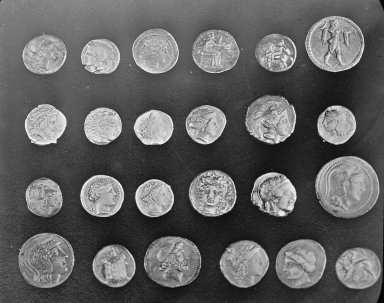

In [ ]:
image = data.coins()

fig = make_subplots(rows=1, cols=2, subplot_titles=('Image', 'Histograme'))
fig.add_trace( px.imshow(image, binary_string=True).data[0], row=1, col=1)
fig.add_trace( go.Histogram(x=image.flatten()), row=1, col=2)
fig.update_xaxes(title_text="nombre de pixels", row=1, col=2)
fig.update_yaxes(title_text="niveau de gris", row=1, col=2)
fig.show()


**Question 3:** Y a t-il, à observer l'histogramme, un seuil séparant nettement les pièces du fond ?

**Réponse 3:** 
Oui, on remarque en effet des traits sur certaines valeurs de niveau de gris de l'histogramme qui séparent nettement les pieces du fond.

## Détections manquées, fausses alarmes

Le code ci-dessous réalise un simple seuillage (variable `seuil` dans le code) sur le niveau de gris de chaque pixel, pour décider si ce pixel appartient à la classe 'pièces' ou non. L'image de détection est indiquée ci-dessous


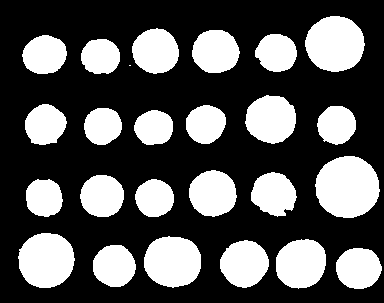
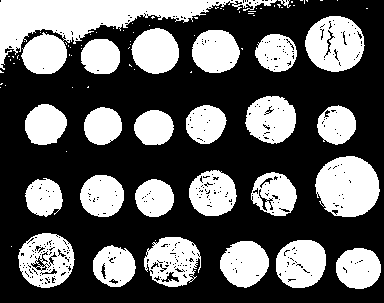


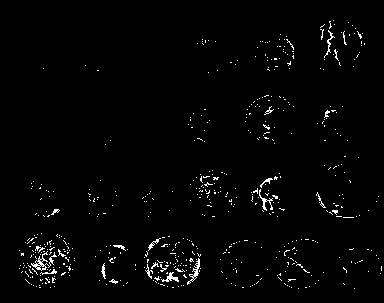
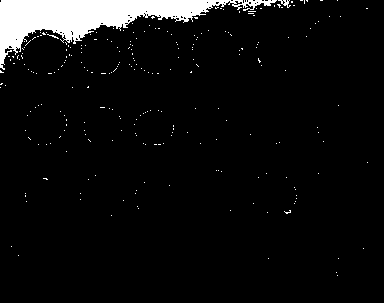

In [ ]:
coins_truth=io.imread('coins_ground_truth.png')
nb_el = nb_lignes * nb_colonnes

seuil = 110

decision = (data.coins()>seuil).astype(int)*255
false_alarm  = np.greater(decision,coins_truth)
misdetection = np.less(decision,coins_truth)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Vérité terrain', 'blanc = decision favorable à la classe "pièce" '))
fig.add_trace( px.imshow(coins_truth, binary_string=True).data[0], row=1, col=1)
fig.add_trace( px.imshow(decision, binary_string=True).data[0], row=1, col=2)
fig.show()
fig = make_subplots(rows=1, cols=2, subplot_titles=('blanc = détections manquées', 'blanc = fausses alarmes'))
fig.add_trace( px.imshow(misdetection, binary_string=True).data[0], row=1, col=1)
fig.add_trace( px.imshow(false_alarm, binary_string=True).data[0], row=1, col=2)
fig.show()

misd=[]
fal=[]

for i in range(0,256):
    decision = (data.coins()>i).astype(int)*255
    false_alarm  = np.greater(decision,coins_truth)
    misdetection = np.less(decision,coins_truth) 
    misd.append(1-np.count_nonzero(misdetection)/nb_el)
    fal.append(np.count_nonzero(false_alarm)/nb_el)
    if i==seuil:
        misdx=1-np.count_nonzero(misdetection)/nb_el
        faly=np.count_nonzero(false_alarm)/nb_el

fig = px.line(x=fal,y=misd, range_x=[0,1], range_y=[0,1])
fig.update_layout( title_text="Courbe 'ROC'", title_x=0.5, showlegend=False, width=600)
fig.update_xaxes(title_text="taux de fausses alarmes")
fig.update_yaxes(title_text="taux de bonne détection")
fig.add_trace(go.Scatter(x=[faly], y=[misdx], text=["seuil="+str(seuil)]))
fig.show()

**Question 4:** 
* De façon générale, quels sont les deux types d'erreurs possibles dans un problème de détection ?
* Une courbe dite "ROC" est indiquée en bas à droite avec une croix sur la position correspondant au seuil réglé.
    * Pour calculer cette courbe comme fait ici, a-t-on besoin de disposer de la "vraie image de détection" ? 
    * A quelles situations correspondent les 4 coins du graphique ? 
    * Trouver différents réglages du seuil permettant de balayer la courbe.
    * Quelle est la situation optimale ?

**Réponse 4:** 
 Les deux types d'erreurs possibles dans un problème de détection sont :

1.   l'erreur de 1ere espèce (ou l'erreur alpha) : C'est lorsque l'hypothèse nulle est vérifiée mais qu'on la rejette. C'est à dire qu'on a manqué la détection. 
2.   l'erreur de 2eme espèce (ou l'erreur beta) : C'est lorsque l'hypthèse nulle est fausse et qu'on ne la rejette pas. C'est à dire que c'est une fausse alarme, on a détecté quelques choses qui n'a pas du l'être. 

Pour calculer cette courbe on a besoin de disporser de la "vraie image de détection"
Les 4 coin du graphiques correspondentaux cas extrêmes: 
soit (x,y) avec x:taux faux alarmes, y: taux de bonne detection
(0,0): résultat nulle, rien n'est detecté
(0,1): detection parfait
(1,0): detection totalement défaillant
(1,1): detection intutile car le taux de bonne detection = taux fausse alarme, c'est comme si tous les détections positives étaient des fausses alarmes. 

La situation optimale correspond au taux de detection= 1 et au taux de fausse alarme = 0. 

# Classification statistique supervisée

On va maintenant automatiser le réglage du seuil de décision, grâce à un apprentissage préalable de la distribution des niveaux de gris de chacune des deux classes.

On a découpé, à la main, deux petites images, l'une extraite du fond et l'autre extraite d'une pièce, pour constituer des données d'apprentissage.
    

## Partie apprentissage  : modélisation de la distribution de probabilité des niveaux de gris pour chacune de ces deux classes.

On calcule la moyenne et la variance de chacun des deux échantillons et on utilise ces moyennes et variances comme paramètres de deux lois normales modélisant la distribution de probabilité des niveaux de gris pour chaque classe. 

In [ ]:
coins_background = io.imread("coins_background4.jpg")
coins_foreground = io.imread("coins_foreground.jpg")

mean_background = coins_background.flatten().mean()
mean_foreground = coins_foreground.flatten().mean()
variance_background = coins_background.flatten().var()
variance_foreground = coins_foreground.flatten().var()
x = np.linspace(0,255,255)

fig = go.Figure()
fig.add_trace(go.Histogram(x=coins_foreground.flatten(), histnorm='probability density', opacity=0.3, name="distribution de probabilité 'foreground'", offsetgroup=0))
fig.add_trace(go.Histogram(x=coins_background.flatten(), histnorm='probability density', opacity=0.3, name="distribution de probabilité 'background'", offsetgroup=0))
fig.add_trace(go.Scatter(x=x,y=stats.norm.pdf(x,mean_background,math.sqrt(variance_background)), name="moyenne/ecart-type 'background'"))
fig.add_trace(go.Scatter(x=x,y=stats.norm.pdf(x,mean_foreground,math.sqrt(variance_foreground)), name="moyenne/ecart-type 'foreground'"))
#j'ai constaté une inversement dans les noms des courbes que j'ai corrigé
fig.update_layout( title_text="Distribution des données et modélisation par moyenne et ecart-type", title_x=0.5, width=1000)
fig.update_xaxes(title_text="niveau de gris")
fig.update_yaxes(title_text="nombre de pixels")
fig.show()


**Question 5:** Au vu des graphiques ci-dessous :
* dans quelle mesure l'hypothèse "loi gaussienne" est-elle valable ?
* quel est le seuil de décision implicitement construit ?

**Réponse 5:** 
Ici, on peut constaté que la distribution du background ne suit pas la loi gaussienne car elle estr trop dispersé par rapport aux courbes de la variance. 

Le seuil de décision implicitement construit se trouve dans l'intersection des deux courbes verts et violets.

**Question 6:** Pour étudier la dépendence du choix du jeu d'apprentissage extrait à la main, on a extrait à la main d'autres zones du fond (`coins_background2.jpg,coins_background3.jpg,coins_background4.jpg`), pour voir si cela affecte les résultats. 
* Vos réponses à la question 5 sont elle différentes avec ces autres jeux d'apprentissage ?
* Les résultats (c.a.d. la qualité) de la classification varient-ils fortement selon les cas ? Est-ce un problème ?

**Réponse 6:** 
Oui, avec les autres jeux d'apprentissages, on constate que la distribution background suit bien la loi gaussienne avec coins_background.jpg, un peu moins avec coins_background3.jpg mais c'est toujours mieux qu'avec coins_background2.jpg. 
On constate pour coins_background4.jpg une modification au niveau de la partie foreground qui s'est éloigné de la loi gaussienne. 

On peut alors constaté que les résultats de la classifications varient selon les cas, cependant, ça permet d'enrichir un peu plus les jeux de données donc cela ne peut pas être considéré comme un problème en soi. 

## Classifions chacun des pixels de l'image selon le critère du maximum de vraisemblance

On peut utiliser les modèles probabilistes construits ci-dessus pour maintenant classer chaque pixel de l'image selon le critère du maximum de vraisemblance. 



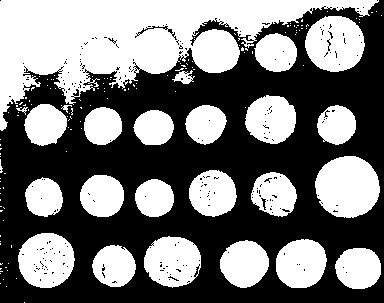

In [ ]:
image_classification = image.copy()

# calcul de fonction gaussienne vectorisé sur une image
image_likelihood_foreground = stats.norm.pdf(image,mean_foreground,math.sqrt(variance_foreground))
image_likelihood_background = stats.norm.pdf(image,mean_background,math.sqrt(variance_background))

# opérateur de comparaison vectorisé sur une image
image_classification= image_likelihood_foreground>image_likelihood_background

fig=px.imshow(image_classification, binary_string=True)
fig.update_layout( title_text="Résultat de la classification par maximum de vraisemblance", title_x=0.5)
fig.show()

## Post-traitement du résultat de classification par morphologie mathématique

<u>De la section précédente, retenir le cas correspondant à la meilleure image de détection</u> (même si elle est loin d'être parfaite). 

On va maintenant tenter de l'améliorer avec des opérations de morphologie mathématique.


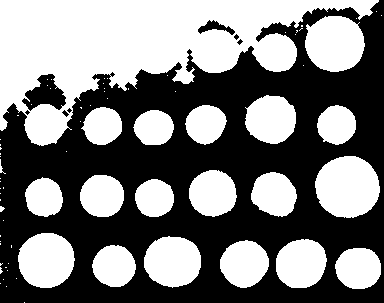

In [ ]:
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk

struct_elem = disk(2)

eroded = erosion(dilated, struct_elem)
dilated = dilation(image_classification, struct_elem)

fig=px.imshow(eroded, binary_string=True)
fig.update_layout( title_text="Résultat de la classification après traitement par morphologie mathématique", title_x=0.5)
fig.show()


**Question 7:**
* Quelle opération de morphologie mathématique permet de boucher les petits trous noirs dans le résultat précédent ?
* Quel est l'inconvénient de cette opération pour la précision des contours des pièces ?
* Comment rétablir à peu près la bonne localisation des contours des pièces ?
* Expérimenter l'inversion de l'ordre dilatation/erosion ci-dessous et des éléments structurants plus grands (changer la taille du disque). Quel réglage semble optimal ?

**Réponse 7:** L'opération de Dilatation permet de boucher les petits trous noirs. Elle permet d'agrandir la taille des objets dans l'image.
Ainsi, avec la dilatation, les contours des pièces ne sont plus aussi précis que l'original  puisqu'il tend à être uniforme. 
Afin de rétablir la bonne localisation des contours des pièces 

Afin de rétablir la bonne localisation des contours, on utilise la dualité Dilatation/Erosion :
Lla fermeture qui est la dilatation suivie de l'érosion rebouche toutes les parties du fond plus étroites que l'élément structurant, et déforme les coins concaves de la figure. 

Dualement,l 'ouverture ou la composition de l'érosion suivie de la dilatation élimine dans une figure toutes les parties plus étroites que l'élément structurant, et en déforme les coins convexes. 

Selon mes observations, c'est l'ouverture qui correspond au mieux et donne un résultat meilleur dans le visuel

## Classification non supervisée d'image

Dans cette section, on examine la possibilité de trouver automatiquement les régions, homogènes au sens de la couleur, composant une image. Pour cela, l'algorithme k-means est utilisé

Automatically created module for IPython interactive environment



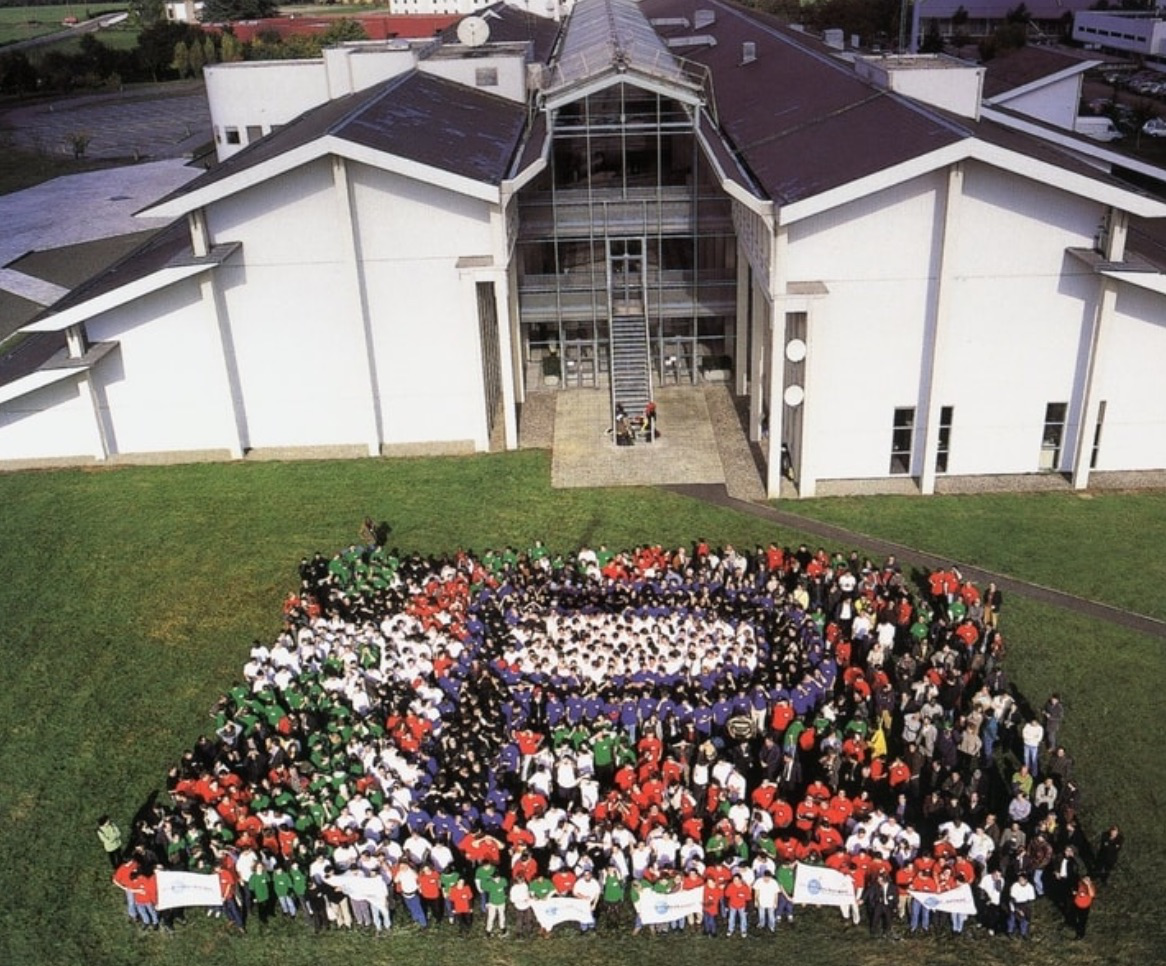
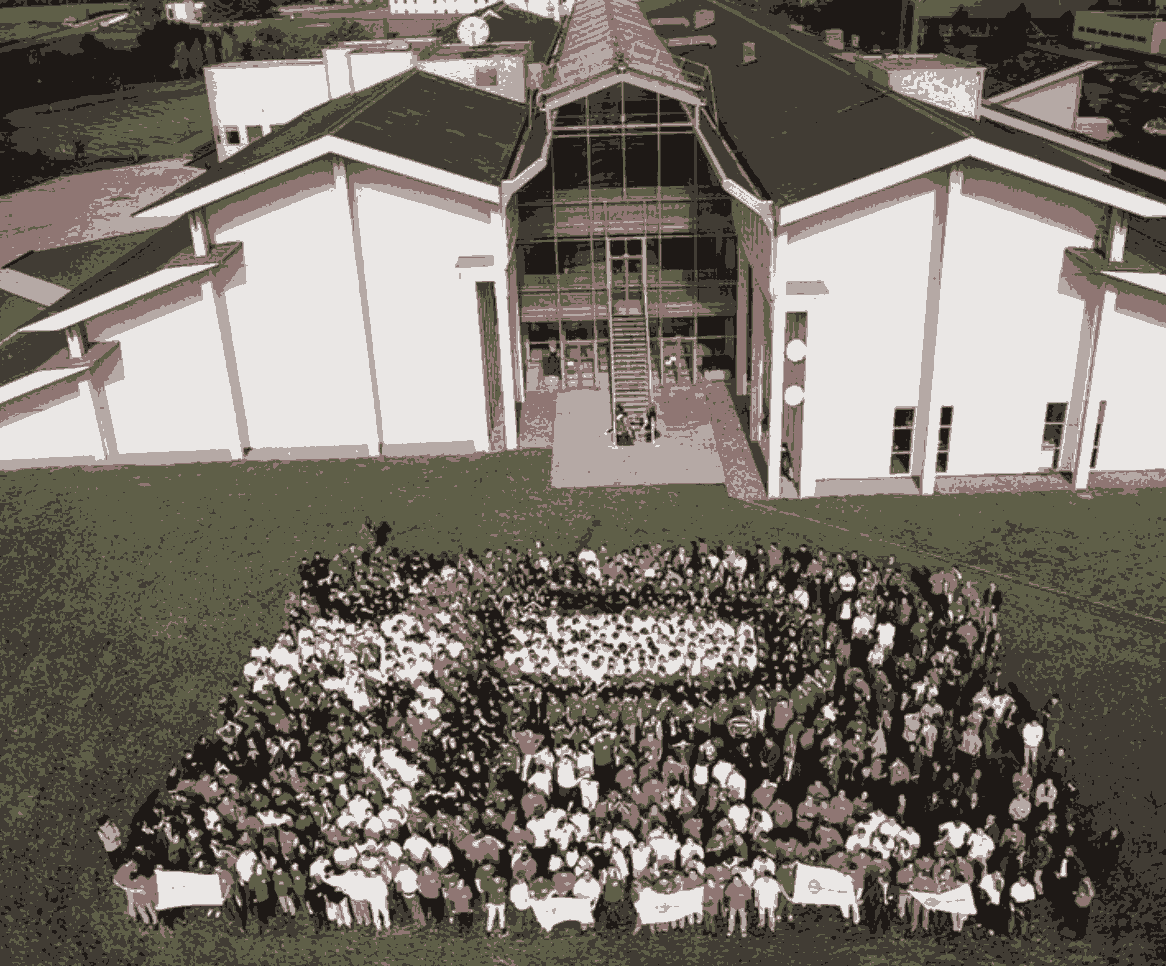

In [ ]:
# Adapté de :
#
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 6


image = io.imread("polytech.jpg")
image = np.array(image, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))

# Fitting model on a small sub-sample of the data (1000 pixels)
#image_array_sample = shuffle(image_array, random_state=0)[:1000]
#kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
# or ...
# Fitting model on all the data
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array)

labels = kmeans.predict(image_array)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

image_regions = recreate_image(kmeans.cluster_centers_, labels, w, h)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Image originale', 'Régions'))
fig.add_trace( px.imshow(image).data[0], row=1, col=1)
fig.add_trace( px.imshow(image_regions).data[0], row=1, col=2)
fig.show()

**Question 8:**
* Essayer l'opération sur des images diverses
* Essayer avec divers nombres de régions
* Pour un nombre restreint de couleur : se représenter l'espace de couleur, les centres des groupes. Y a t-il besoin de calculer des distances entre couleurs ?
* Les régions trouvées sont-elles spatialement connexes ? Pouvez-vous trouver des avantages et inconvénients à cela ?
* Comment cette technique pourrait-elle servir à faire de la compression d'image ?

**Réponse 8:** 
Pour un nombre restreint de couleur, on peut remarqué la classification des différents régions selon la valeur du pixel, donc on a toujours besoins de calculer les distances entre couleurs pour voir à quelle classe on doit affecter la régions. 

Les régions trouvés ne sont pas obligatoirement spagtialement connexes. Cela permet d'un coté de voir le contraste dans les différents régions qui donne une bonne classification. 

Cette technique est utile pour la compression d'image car elle permet de detecter les différentes régions de l'image ainsi on pourrait réduire le poids des données sans trop en altérer la qualité 